# Set up

Setting up libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Data

/content/drive/My Drive/Colab Notebooks/Data


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import pickle
import seaborn as sns

from skimage.transform import radon, iradon
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

# Opening variables with pickle

In [4]:
with open('variables', 'rb') as f:
   train,train_labs,valid,valid_labs,test,test_labs,test_labels = pickle.load(f)

# Standard model

In [ ]:
inception = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(256,256,3)
)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= inception.input , outputs = x)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
loss_fn_name = "categorical_crossentropy"
Metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=loss_fn_name, metrics=Metrics)

In [ ]:
mcp = tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='val_accuracy', mode='max', save_best_only=True)

history = model.fit(train, train_labs, epochs=35, batch_size=64, validation_data=(valid, valid_labs),callbacks=[mcp])

Epoch 1/35
10/10 [==============================] - 127s 12s/step - loss: 278419.4375 - accuracy: 0.2795 - precision: 0.2795 - recall: 0.2795 - auc: 0.5197 - val_loss: 164986.8125 - val_accuracy: 0.4028 - val_precision: 0.4028 - val_recall: 0.4028 - val_auc: 0.6019
Epoch 2/35
10/10 [==============================] - 110s 11s/step - loss: 69664.9453 - accuracy: 0.4376 - precision: 0.4376 - recall: 0.4376 - auc: 0.6251 - val_loss: 54564.5781 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583 - val_auc: 0.6389
Epoch 3/35
10/10 [==============================] - 111s 11s/step - loss: 32865.7148 - accuracy: 0.5424 - precision: 0.5424 - recall: 0.5424 - auc: 0.6950 - val_loss: 16634.6797 - val_accuracy: 0.5556 - val_precision: 0.5556 - val_recall: 0.5556 - val_auc: 0.7040
Epoch 4/35
10/10 [==============================] - 100s 10s/step - loss: 13618.0938 - accuracy: 0.5724 - precision: 0.5724 - recall: 0.5724 - auc: 0.7149 - val_loss: 15675.1943 - val_accuracy: 0.4722 - val

In [5]:
best_model = load_model('model.h5')
best_model.evaluate(x = test, y = test_labs, verbose=1)

10/10 [==============================] - 49s 5s/step - loss: 3534.8579 - accuracy: 0.5492 - precision: 0.5492 - recall: 0.5492 - auc: 0.6995


[3534.85791015625,
 0.5492063760757446,
 0.5492063760757446,
 0.5492063760757446,
 0.6994708776473999]

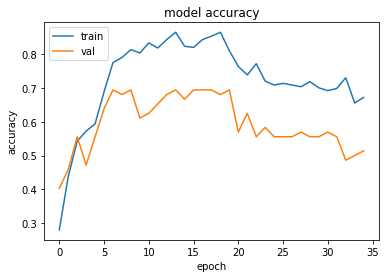

In [ ]:
sns.reset_orig()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

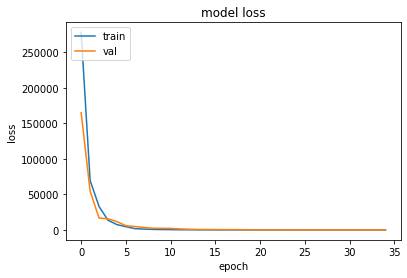

In [ ]:
sns.reset_orig()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
preds = best_model.predict(test)

In [7]:
cf_matrix = confusion_matrix(test_labels, np.round(preds).argmax(axis=1))

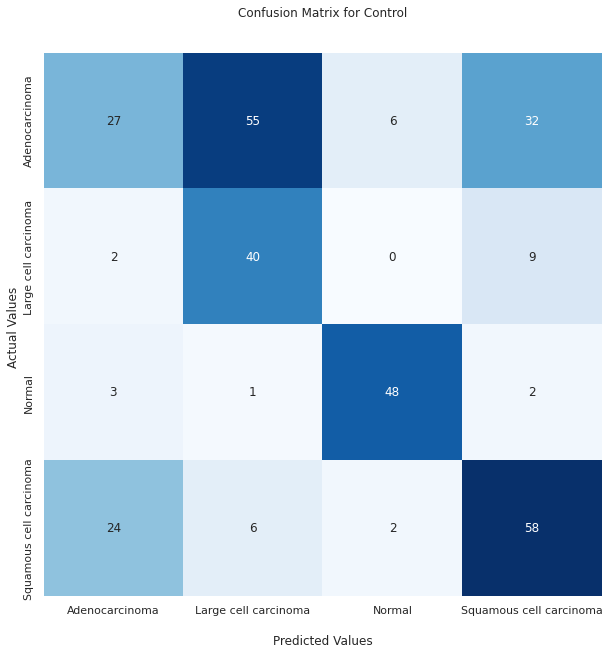

In [8]:
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',cbar=False,fmt='g')

ax.set_title('Confusion Matrix for Control\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])
ax.yaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])

plt.show()

In [9]:
def four_to_two(pred):
  pred_2 = [] 
  for i in range(len(pred)):
    if pred[i] == 0 or pred[i] == 1 or pred[i] == 3: 
      pred_2.append(1)
    else:
      pred_2.append(0)
  return pred_2

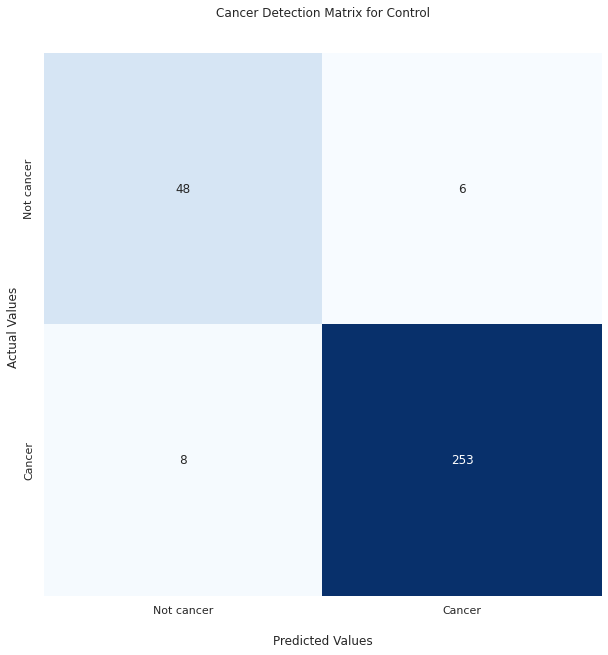

In [10]:
preds_in_one = preds.argmax(axis=1)

new_pred = four_to_two(preds_in_one)
new_test_labels = four_to_two(test_labels)

cf_matrix_2 = confusion_matrix(new_test_labels, new_pred)

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix_2, annot=True, cmap='Blues',cbar=False,fmt = 'g')

ax.set_title('Cancer Detection Matrix for Control\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Not cancer','Cancer'])
ax.yaxis.set_ticklabels(['Not cancer','Cancer'])

plt.show()

# Metrics

In [ ]:
def scores(y_true, y_pred, labels):
  acc = metrics.accuracy_score(y_true, y_pred.argmax(axis=1))
  acc_k = metrics.top_k_accuracy_score(y_true, y_pred, k=2)
  acc_3 = metrics.top_k_accuracy_score(y_true, y_pred, k=3)
  prec = metrics.precision_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  rec = metrics.recall_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  roc_auc = metrics.roc_auc_score(labels, y_pred)

  print('Accuracy is :',round(acc,3))
  print('Top 2 Accuracy is :',round(acc_k,3))
  print('Top 3 Accuracy is :',round(acc_3,3))
  print('Precision is :',round(prec,3))
  print('Recall is :',round(rec,3))
  print('AUC is :',round(roc_auc,3))

In [ ]:
scores(test_labels,preds,test_labs)

Accuracy is : 0.549
Top 2 Accuracy is : 0.66
Top 3 Accuracy is : 0.702
Precision is : 0.558
Recall is : 0.549
AUC is : 0.743
